In [1]:
from data_processing import process_mat_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_extreme import ClimateExtreme
import climate_stats as cs
import scipy.stats as stats

from BucketModel import BucketModel, BucketModelOptimizer
from BucketModel.data_processing import (
    preprocess_for_bucket_model,
    run_multiple_simulations,
)
from BucketModel.bucket_model_plotter import *

from climate_simulation import run_model_for_future_climate, plot_climate_scenarios

from uncertainty_analysis import UncertaintyAnalysis, simulate_and_aggregate_streamflows

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#import statsmodels.tsa.api as smt
#import statsmodels.api as sm

from generate_future_climate import generate_future_climate

import os


import warnings
warnings.filterwarnings("ignore")

## (WEEK 1) Simulating ensembles with the WeaGETS weather generator.
### Reading in the input data and the output files from WeaGETS

<div style="background-color: #3b1d1d; padding: 12px 16px; border-radius: 6px; border-left: 4px solid #ff7f7f; margin: 10px 0; color: #ffffff; display: inline-block;">
⚠️ <strong>Important:</strong> Store the simulated data (the .mat files) in the <strong>data</strong> folder!
</div>

first_run_results: threshold 0.1, n=50 (1500), 1st order markov, skewed normal

In [2]:
input_data_path = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/WeaGETS/Ex3-WeaGETS/Ex3-WeaGETS/HONDRICH_WEAGETS_IN.mat" #Your path to the OBSERVATIONS dataset
simulation_path = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/First_run_results.mat" #Your path to the WeaGETS SIMULATIONS dataset

#Process the MATLAB files to a suitable format
present_data = process_mat_file(input_data_path)
latterbach_out = process_mat_file(simulation_path)


In [3]:
# Inspect the OBSERVATIONS (see the number of datapoints - rows, compare it with the WeaGETS output)
present_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day
0,7.6,-5.6,-9.2,-7.40,1980,Jan,1
1,4.8,-8.5,-11.1,-9.80,1980,Jan,2
2,1.4,-9.6,-13.4,-11.50,1980,Jan,3
3,6.9,-10.7,-13.4,-12.05,1980,Jan,4
4,4.6,-7.0,-13.9,-10.45,1980,Jan,5
...,...,...,...,...,...,...,...
10945,0.1,-12.5,-17.8,-15.15,2009,Dec,27
10946,3.5,-10.5,-15.0,-12.75,2009,Dec,28
10947,1.1,-13.2,-18.3,-15.75,2009,Dec,29
10948,5.3,-5.7,-19.1,-12.40,2009,Dec,30


In [4]:
# Inspect the WeaGETS SIMULATIONS (notice that you have a "Simulation" column marking the ordinal number of the realisation)
latterbach_out

,Precipitation,T_max,T_min,Year,Simulation,T_avg,Month,Day
0,5.077892,1.607168,-5.011958,1980,1,-1.702395,Jan,1
1,12.621673,0.150395,-4.591559,1980,1,-2.220582,Jan,2
2,0.000000,6.982217,0.205677,1980,1,3.593947,Jan,3
3,0.200000,7.937353,-1.365316,1980,1,3.286018,Jan,4
4,3.512833,8.129392,-3.341651,1980,1,2.393871,Jan,5
...,...,...,...,...,...,...,...,...
547495,2.014272,3.241594,-3.166535,2009,50,0.037529,Dec,27
547496,0.000000,5.963460,-1.712151,2009,50,2.125654,Dec,28
547497,0.000000,0.922706,-7.486905,2009,50,-3.282099,Dec,29
547498,3.742196,1.509634,-5.407472,2009,50,-1.948919,Dec,30


## Looking at climate statistics to compare generated data to observed data
### Comparing number of wet days (Precipitation > 0.1 mm) in the generated data to the observed data

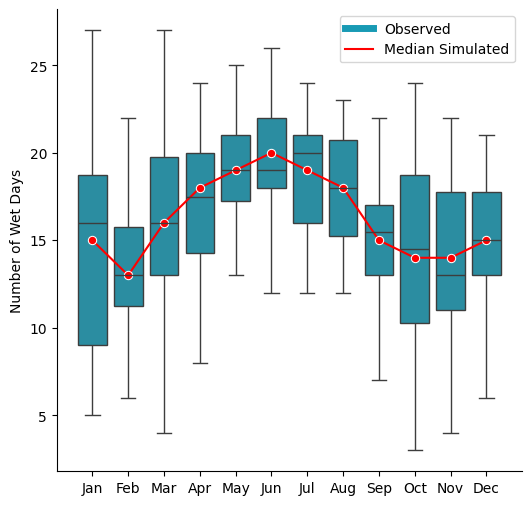

In [5]:
cs.plot_wet_days(
    present_data,
    latterbach_out
) # You can add the output_destination parameter to save the plot

### Comparing the Estimated Cumulative Distribution Function (ECDF) of the two datasets for Precipitation

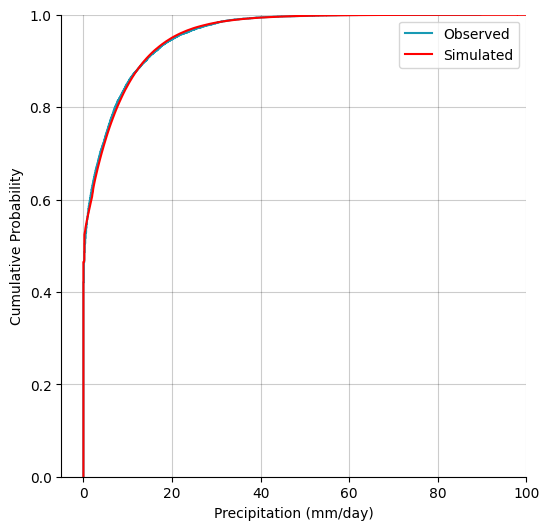

In [6]:
cs.plot_ECDF(
    observations=present_data,
    simulation=latterbach_out,
    column="Precipitation",
    xlabel="Precipitation (mm/day)",
)

### Comparing mean and standard deviation of Average Temperature values

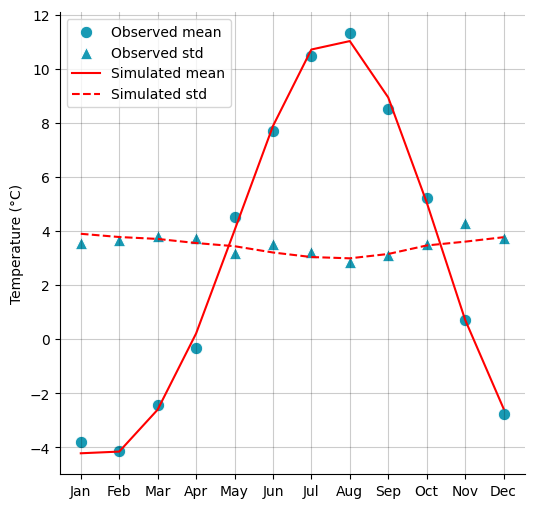

In [7]:
cs.plot_mean_and_std(observations=present_data, simulation=latterbach_out)

### Compare the extreme values - Plot the distributions above a given quantile for visual inspection

In [8]:
# Create instances of ClimateExtreme Class
observed = ClimateExtreme(present_data)
latterbach = ClimateExtreme(latterbach_out)

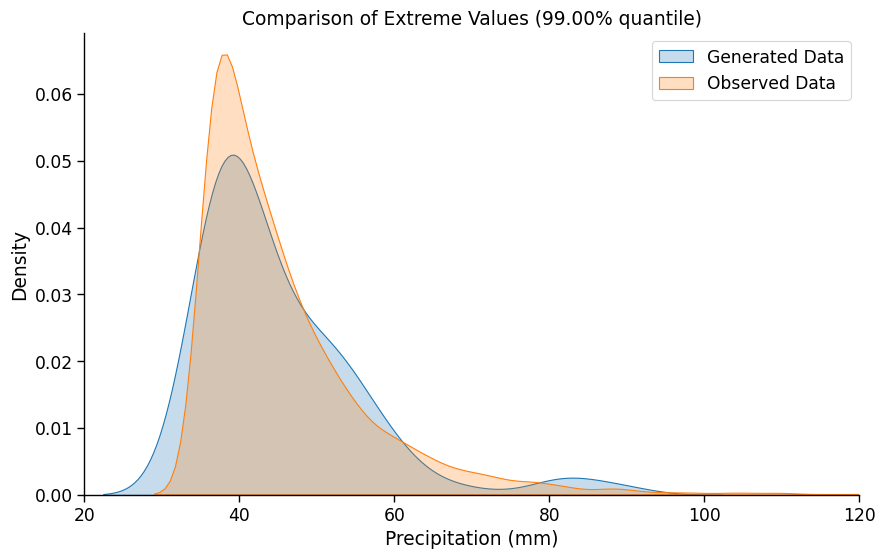

In [9]:
#These plots contain the data points 
observed.plot_extreme_comparison(column="Precipitation", other=latterbach, quantile=0.99, output_destination="", units="mm")

### Perform the KS test for each WeaGETS realisation against the extremes of the observations

KS Tests Completed.


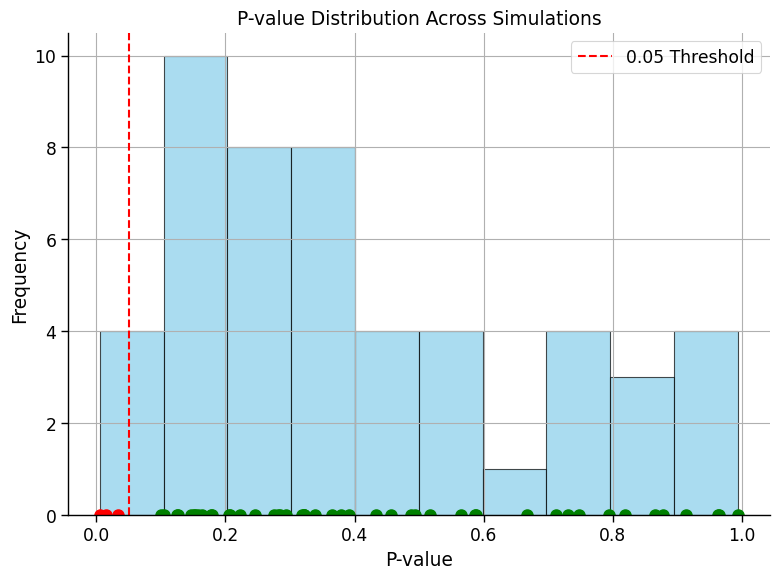

In [10]:
# Call the run_simulation_ks_tests method
ks_results = latterbach.run_simulation_ks_tests(
    observed_data=observed,          # Pass the observed data instance
    column="Precipitation",     # Specify the column to compare
    quantile=0.95               # Specify the quantile for truncation
)

# Output the results
latterbach.plot_ks_results(ks_results)

## Testing different simulation methods:

In [47]:
# folder path für die location der matlab files
folder_path = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/present_simulations/"

filenames = ["1st_exp.mat", "1st_gamma.mat", "1st_skewed.mat", "1st_mixed.mat","2nd_exp.mat", "2nd_gamma.mat", "2nd_skewed.mat", "2nd_mixed.mat","3rd_exp.mat", "3rd_gamma.mat", "3rd_skewed.mat", "3rd_mixed.mat"]

filenames_skewed = ["1st_skewed.mat", "2nd_skewed.mat", "3rd_skewed.mat"]
filenames_gamma = ["1st_gamma.mat",  "2nd_gamma.mat", "3rd_gamma.mat"]
filenames_exp = ["1st_exp.mat", "2nd_exp.mat", "3rd_exp.mat"]
filenames_mixed = ["1st_mixed.mat", "2nd_mixed.mat", "3rd_mixed.mat"]
filenames_first = ["1st_exp.mat", "1st_gamma.mat", "1st_skewed.mat", "1st_mixed.mat"]
filenames_second =  ["2nd_exp.mat", "2nd_gamma.mat", "2nd_skewed.mat", "2nd_mixed.mat"]

filenames_chosen = ["1st_exp.mat", "2nd_mixed.mat" ]

### Comparison of extreme values

In [28]:
def plot_extreme_comparison_multi(
    filename,
    simulated_extremes,
    observed_extremes,
    column: str,
    units: str,
    quantile: float = 0.95,

) -> None:
    threshold_self = simulated_extremes.data[column].quantile(quantile)
    extremes_self = simulated_extremes.data[simulated_extremes.data[column] > threshold_self][column].values
    sns.kdeplot(extremes_self, label= filename , shade=True)
    

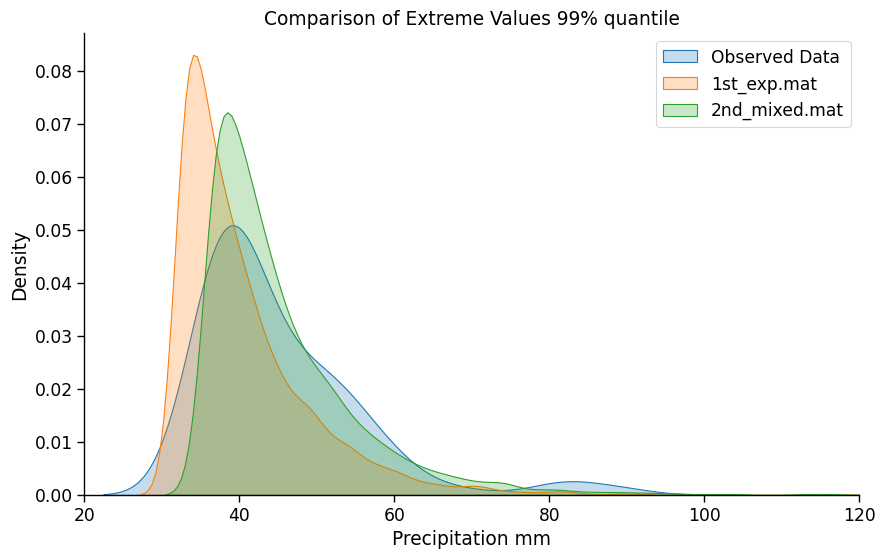

In [53]:
sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=(10, 6))
column="Precipitation"
quantile=0.99
threshold_other = observed.data[column].quantile(quantile)
extremes_other = observed.data[observed.data[column] > threshold_other][column].values
sns.kdeplot(extremes_other, label="Observed Data", shade=True)

for filename in filenames_chosen: #hier gruppe auswählen
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    file_data_extremes = ClimateExtreme(file_data)
    plot_extreme_comparison_multi(filename, file_data_extremes,observed,  column="Precipitation", quantile=0.99,  units="mm")

plt.title("Comparison of Extreme Values 99% quantile")
plt.xlabel("Precipitation mm")
plt.ylabel("Density")
plt.xlim(20,120)
sns.despine()
plt.legend()
plt.show()

In [34]:
def plot_wet_days_multi(
    observations: pd.DataFrame, simulation: pd.DataFrame, filename
) -> None:
    """Plot the number of wet days from observations and simulation.

    Args:
        observations (pd.DataFrame): The observed data.
        simulation (pd.DataFrame): The simulated data.
        output_destination (str): File path to save the figure. If None, the plot will be displayed instead of saving.
    """
    sim_wet_days = cs.add_is_wet_column(simulation)
    sim_grouped = cs.group_data(sim_wet_days, ["Simulation", "Year", "Month"])
    sim_median = sim_grouped.groupby("Month")["is_wet"].median()


    sns.lineplot(
        data=sim_median, marker="o", label=filename
    )





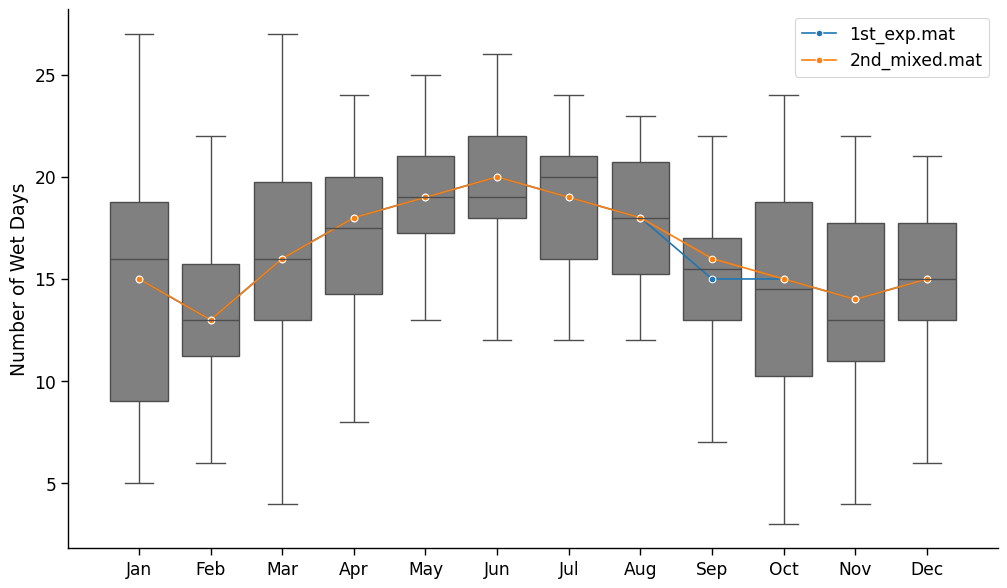

In [54]:
observations=present_data

obs_wet_days = cs.add_is_wet_column(observations)
obs_grouped = cs.group_data(obs_wet_days, ["Year", "Month"])
obs_median = obs_grouped.groupby("Month")["is_wet"].median()

plt.figure(figsize=(10,6))
sns.boxplot(data=obs_grouped, x="Month", y="is_wet", color='gray', showfliers=False)
for filename in filenames_chosen: #hier gruppe auswählen
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    plot_wet_days_multi(observations, file_data, filename)

sns.despine()
plt.legend()
plt.ylabel("Number of Wet Days")
plt.xlabel("")
plt.show()

In [58]:
def plot_mean_and_std_multi(filename, simulation: pd.DataFrame) -> None:
    simul_stats_monthly = cs.calculate_monthly_stats(simulation, include_simulation=True)
    simul_stats_monthly = simul_stats_monthly.groupby("Month_").mean().reset_index()

    sns.lineplot(
        x=simul_stats_monthly["Month_"],
        y=simul_stats_monthly["T_avg_mean"],
        label="Mean " + filename,
        linestyle="-",
    )
    sns.lineplot(
        x=simul_stats_monthly["Month_"],
        y=simul_stats_monthly["T_avg_std"],
        label="Std " + filename,
        linestyle="--",
    )

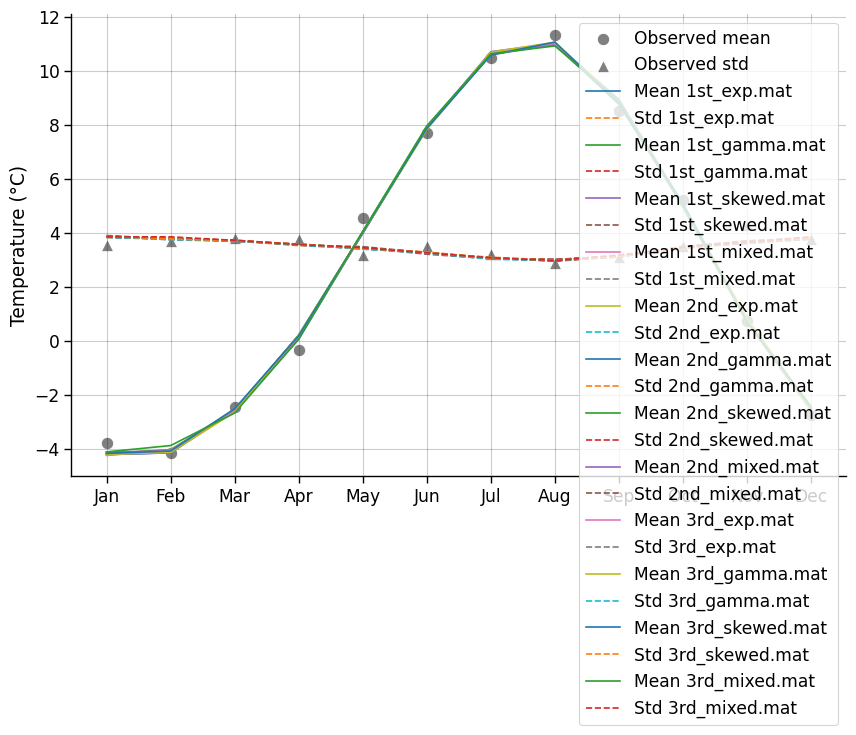

In [60]:
obs_stats_monthly = cs.calculate_monthly_stats(observations)
obs_stats_monthly = obs_stats_monthly.groupby("Month_").mean().reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=obs_stats_monthly["Month_"],
    y=obs_stats_monthly["T_avg_mean"],
    label="Observed mean",
    color='gray',
    marker="o",
    s=80,
)
sns.scatterplot(
    x=obs_stats_monthly["Month_"],
    y=obs_stats_monthly["T_avg_std"],
    label="Observed std",
    color='gray',
    marker="^",
    s=80,
)

for filename in filenames: #hier gruppe auswählen
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    plot_mean_and_std_multi(filename, file_data)

plt.legend()
plt.ylabel("Temperature (°C)")
plt.xlabel("")
plt.grid(linestyle="-", alpha=0.2, color="black")
sns.despine()

plt.show()

C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/present_simulations/1st_exp.mat
KS Tests Completed.


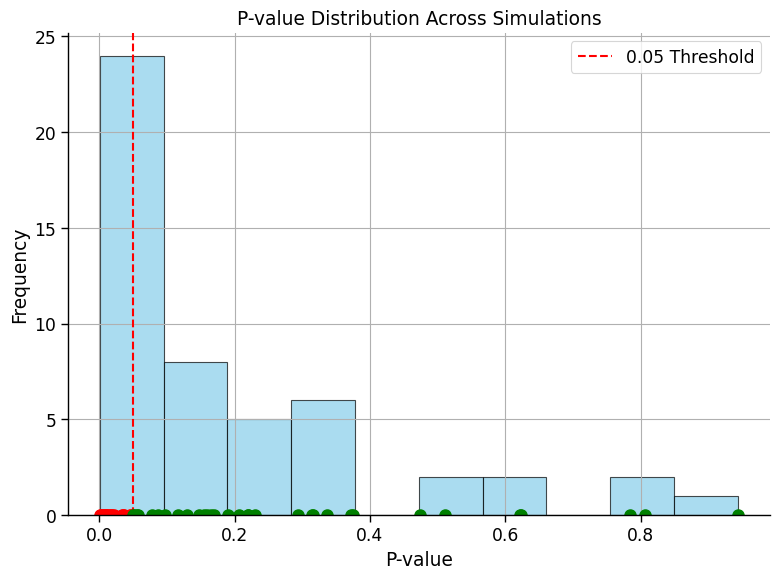

C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/present_simulations/2nd_mixed.mat
KS Tests Completed.


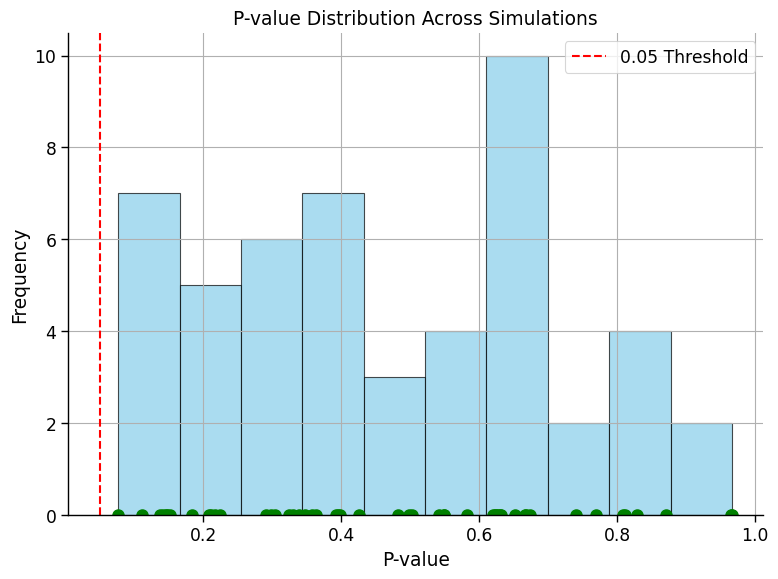

In [55]:
for filename in filenames_chosen:
    file_path = folder_path + filename 
    file_data = process_mat_file(file_path)
    print(file_path)
    #print(file_data)
    #cs.plot_wet_days(present_data, file_data) 
    #cs.plot_mean_and_std(observations=present_data, simulation=file_data)
    #cs.plot_ECDF(observations=present_data,simulation=file_data,column="Precipitation",xlabel="Precipitation (mm/day)")

    file_data_extremes = ClimateExtreme(file_data)
    #observed.plot_extreme_comparison(column="Precipitation", other=file_data_extremes, quantile=0.99, output_destination="", units="mm")

    ks_results = file_data_extremes.run_simulation_ks_tests(observed_data=observed, column="Precipitation", quantile=0.95)
    file_data_extremes.plot_ks_results(ks_results)

  
    

## Running the Bucket Model
#### Preprocessing the data to match the format required by the Bucket Model


In [11]:
processed_present_data = preprocess_for_bucket_model(present_data)
latterbach_preprocessed = preprocess_for_bucket_model(latterbach_out)


In [12]:
processed_present_data

,P_mix,T_max,T_min
date,,,
1980-01-01,7.6,-5.6,-9.2
1980-01-02,4.8,-8.5,-11.1
1980-01-03,1.4,-9.6,-13.4
1980-01-04,6.9,-10.7,-13.4
1980-01-05,4.6,-7.0,-13.9
...,...,...,...
2009-12-27,0.1,-12.5,-17.8
2009-12-28,3.5,-10.5,-15.0
2009-12-29,1.1,-13.2,-18.3


In [13]:
latterbach_preprocessed

,P_mix,T_max,T_min,Simulation
date,,,,
1980-01-01,5.077892,1.607168,-5.011958,1
1980-01-02,12.621673,0.150395,-4.591559,1
1980-01-03,0.000000,6.982217,0.205677,1
1980-01-04,0.200000,7.937353,-1.365316,1
1980-01-05,3.512833,8.129392,-3.341651,1
...,...,...,...,...
2009-12-27,2.014272,3.241594,-3.166535,50
2009-12-28,0.000000,5.963460,-1.712151,50
2009-12-29,0.000000,0.922706,-7.486905,50


### Setting up the model for the catchment. Here I use the calibrated parameters from Assignment 2

In [14]:
bucket_model = BucketModel(
    k=1.0, S_max=48.585, fr=0.102, rg=30.747, snow_threshold_temp=0.29
)  # Parameters from Assignment 2

bucket_model.set_catchment_properties(
    lapse_rate=0.5 / 100,  # °C/m
    basin_mean_elevation=1872,  # m.a.s.l
    hru_mean_elevation=1872,  # m.a.s.l
    snowmelt_temp_threshold=0,  # °C
    latitude=46.5,  # °N
)


### Running the model for the present data and visualising the results

In [15]:
present_results = bucket_model.run(data=processed_present_data)

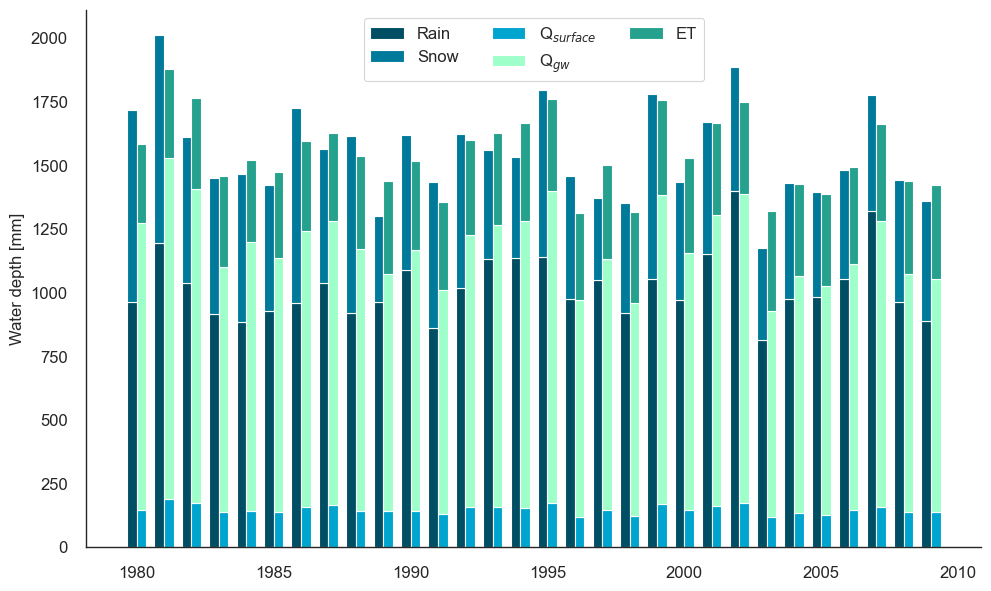

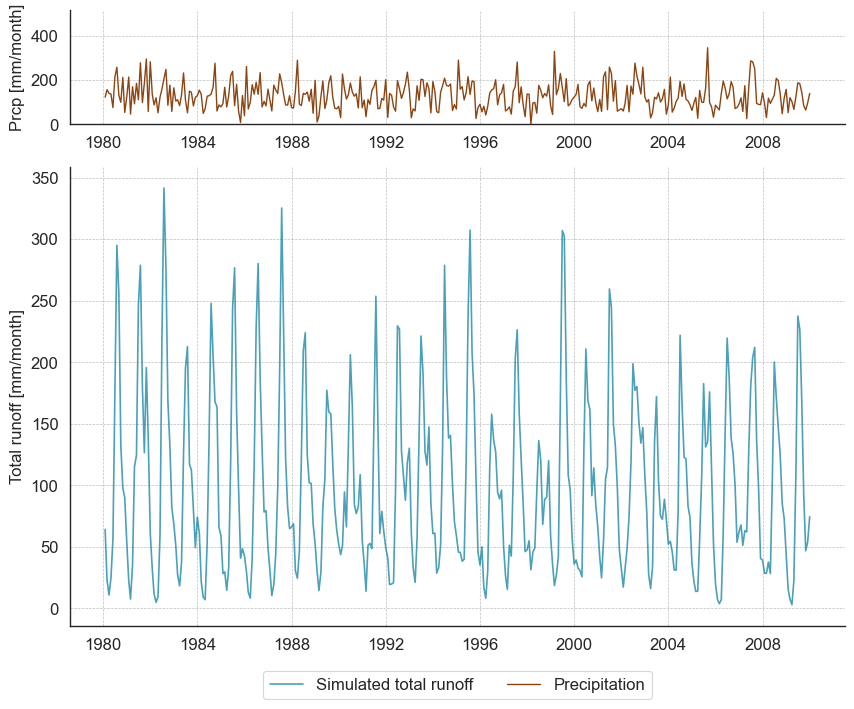

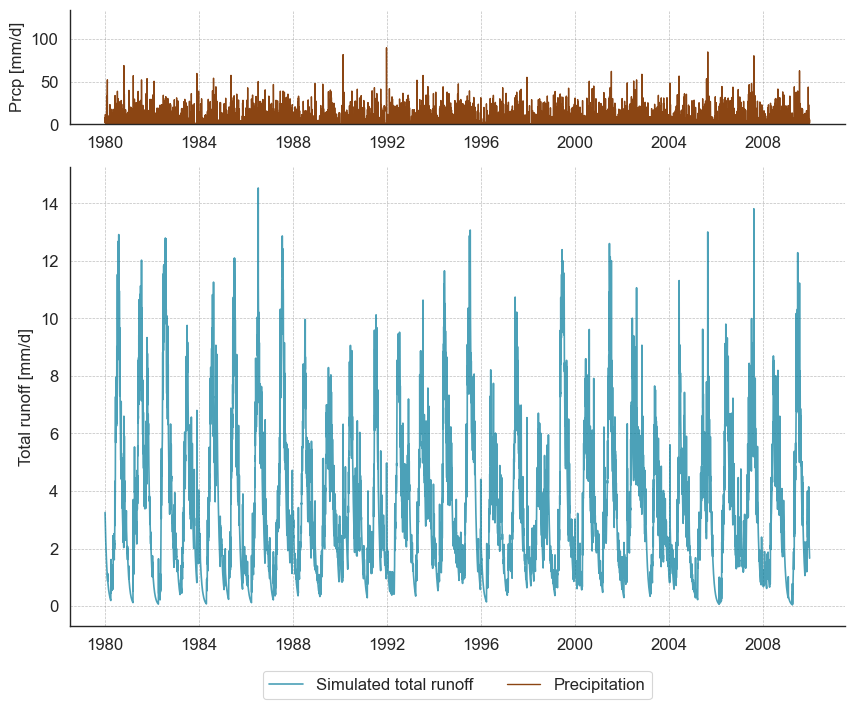

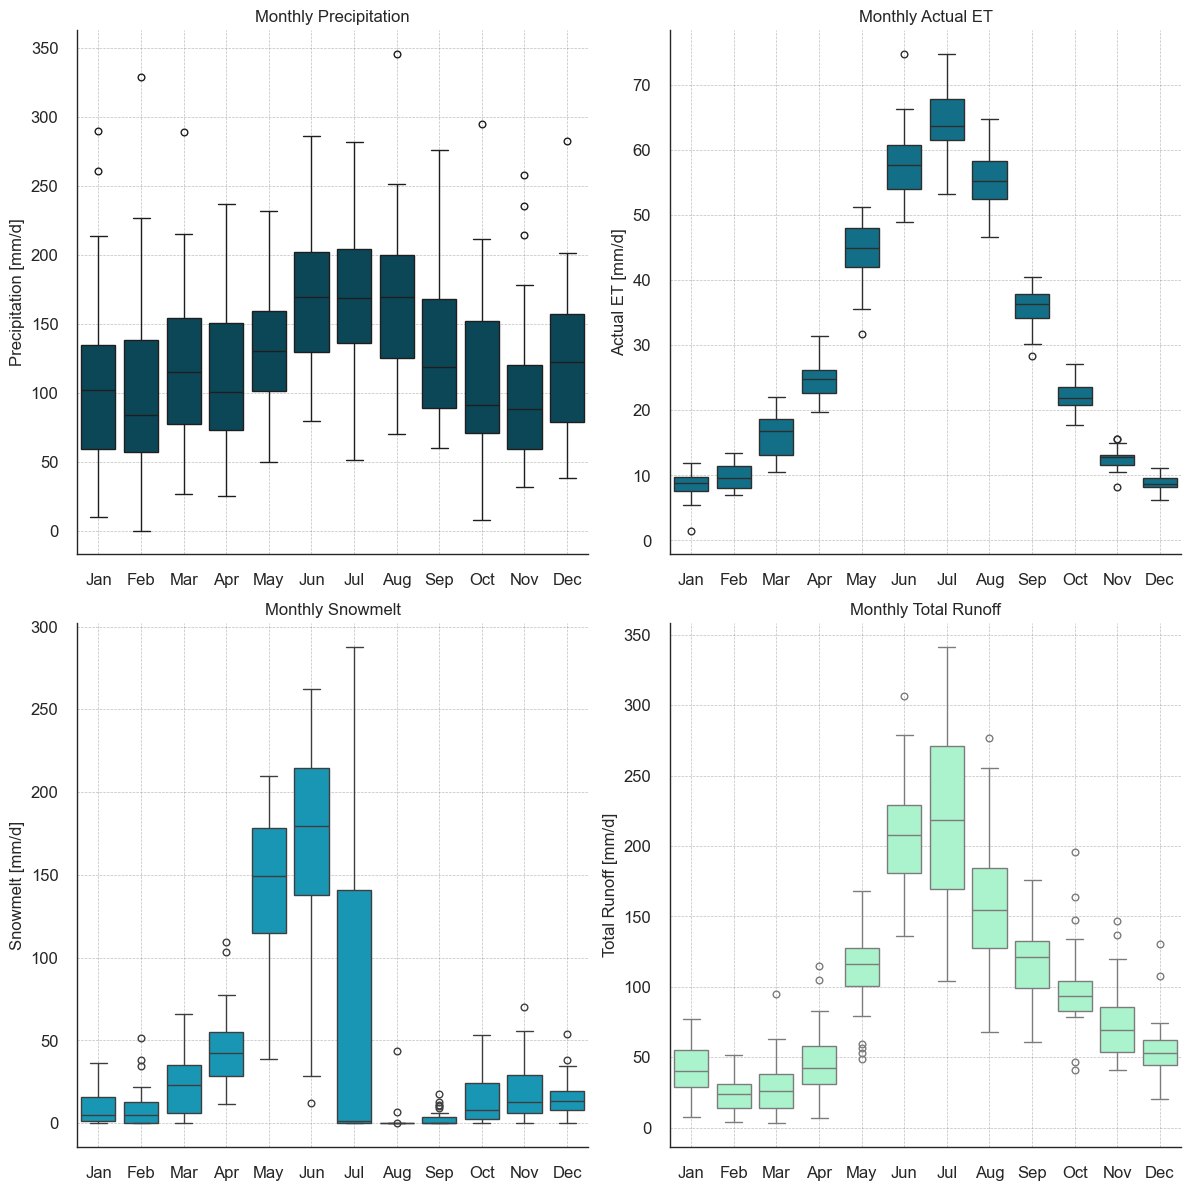

In [16]:
plot_water_balance(results=present_results, start_year="1980", end_year="2010")

plot_timeseries(
    results=present_results,
    start_year="1980",
    end_year="2010",
    monthly=True,
    plot_precipitation=True,
)
plot_timeseries(
    results=present_results,
    start_year="1980",
    end_year="2010",
    monthly=False,
    plot_precipitation=True,
)
plot_monthly_boxplot(results=present_results)

### Run the model for each Simulation individually. Here _Simulation_ refers to the number of 30 years ensembles generated with WeaGETS.

In [17]:
multiple_results = run_multiple_simulations(
    preprocessed_simulated_data=latterbach_preprocessed,
    bucket_model=bucket_model,
    n_simulations=50,
)

In [18]:
multiple_results

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,Simulation
1980-01-01,0.061209,0.000000,3.252350,3.844946,11.171737,96.747650,0.000000,1.232946,3.844946,5.077892,1
1980-01-02,0.066157,0.000000,3.146572,16.466619,11.105580,93.601078,0.000000,0.000000,12.621673,12.621673,1
1980-01-03,0.098428,0.000000,3.044234,12.872671,14.601099,90.556844,3.593947,0.000000,0.000000,0.000000,1
1980-01-04,0.127262,0.000000,2.945225,9.616006,17.930502,87.611618,3.286018,0.170647,0.029353,0.200000,1
1980-01-05,0.147776,0.000000,2.849436,8.245466,22.666099,84.762182,2.393871,2.489503,1.023330,3.512833,1
...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,0.331522,0.107759,1.671317,196.034718,48.585000,50.333848,0.037529,1.018932,0.995339,2.014272,50
2009-12-28,0.383206,0.216817,1.637033,193.909064,48.585000,50.222447,2.125654,0.000000,0.000000,0.000000,50
2009-12-29,0.263766,0.000000,1.633410,193.909064,48.321234,48.589037,0.000000,0.000000,0.000000,0.000000,50
2009-12-30,0.288989,0.083306,1.580285,196.834539,48.585000,47.189412,0.000000,0.816721,2.925475,3.742196,50


### Grouping the results by month and computing the 95% confidence interval

,Simulation,year,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,total_runoff
month,,,,,,,,,,,,,
1,25.5,1994.5,8.262599,2.657653,36.332717,4678.719675,1407.046602,1099.880426,12.288254,17.159268,93.918704,111.077972,38.990370
2,25.5,1994.5,9.581906,2.268726,22.451630,6466.943747,1250.907770,683.353132,11.422690,15.185648,86.432702,101.618350,24.720356
3,25.5,1994.5,15.868057,3.913189,22.011128,9375.489118,1377.787954,680.733531,21.589203,24.877217,87.896586,112.773803,25.924317
4,25.5,1994.5,25.445991,9.431238,36.418253,10563.444638,1391.840156,1147.285841,51.733956,49.520957,69.860320,119.381277,45.849491
5,25.5,1994.5,42.987430,23.360491,86.819742,9546.301778,1491.801671,2748.266432,132.338844,100.533011,28.634435,129.167446,110.180233
6,25.5,1994.5,58.529399,35.657462,178.283609,4638.431098,1441.981552,5563.011714,184.049107,168.569852,6.616809,175.186661,213.941070
7,25.5,1994.5,65.597927,23.787710,201.860637,690.797568,1417.411999,6164.856351,68.108309,178.746856,0.697237,179.444093,225.648347
8,25.5,1994.5,55.103008,15.399052,144.125693,14.485501,1391.147441,4383.873740,2.574225,165.705887,0.377772,166.083659,159.524745
9,25.5,1994.5,37.240188,12.187979,108.902139,5.251914,1366.890154,3320.459595,1.653406,128.056330,2.067787,130.124117,121.090118


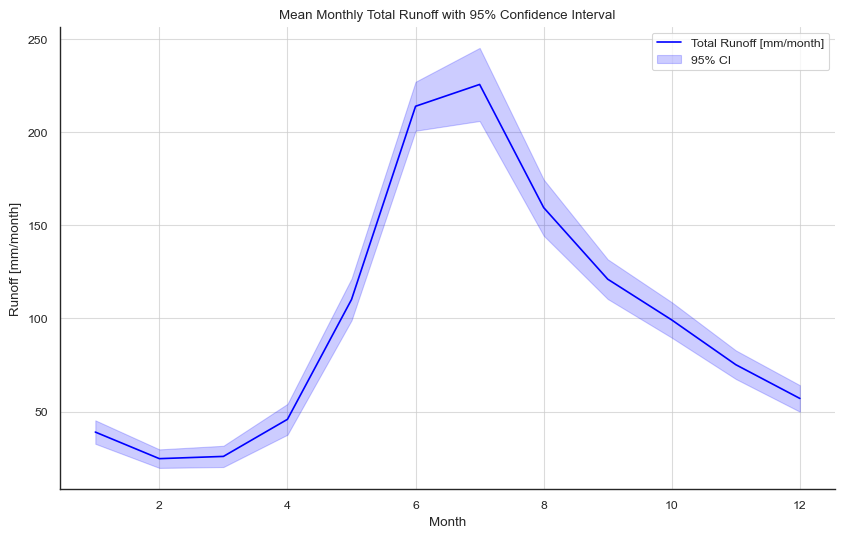

In [19]:
monthly_mean, ci = group_by_month_with_ci(multiple_results)

plot_monthly_runoff_with_ci(monthly_mean, ci)

monthly_mean

# TODO: remove simulation column

## (Week 2) Assessing the changes to streamflow in a future climate
### Generate a future climate ensemble consisting of n multiple realizations (simulations) for 5 climate trajectories (climate models) and 2 different greenhouse gas (GHG) emission scenarios applying the delta-change approach.

In [20]:
generate_future_climate(
    data=latterbach_out,
    name="exp_first",
    output_folder="C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates",
)

Generating future climate data. Be patient...
Future climate data for CLMCOM-CCLM4-ECEARTH RCP4.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-ECEARTH_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-ECEARTH RCP8.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-ECEARTH_RCP8.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP4.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-HADGEM_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP8.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_CLMCOM-CCLM4-HADGEM_RCP8.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP4.5 saved to C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates\exp_first_DMI-HIRHAM-ECEARTH_RCP4.5.csv
Future 

### Simulate future streamflow using the future climate ensemble and the Bucket

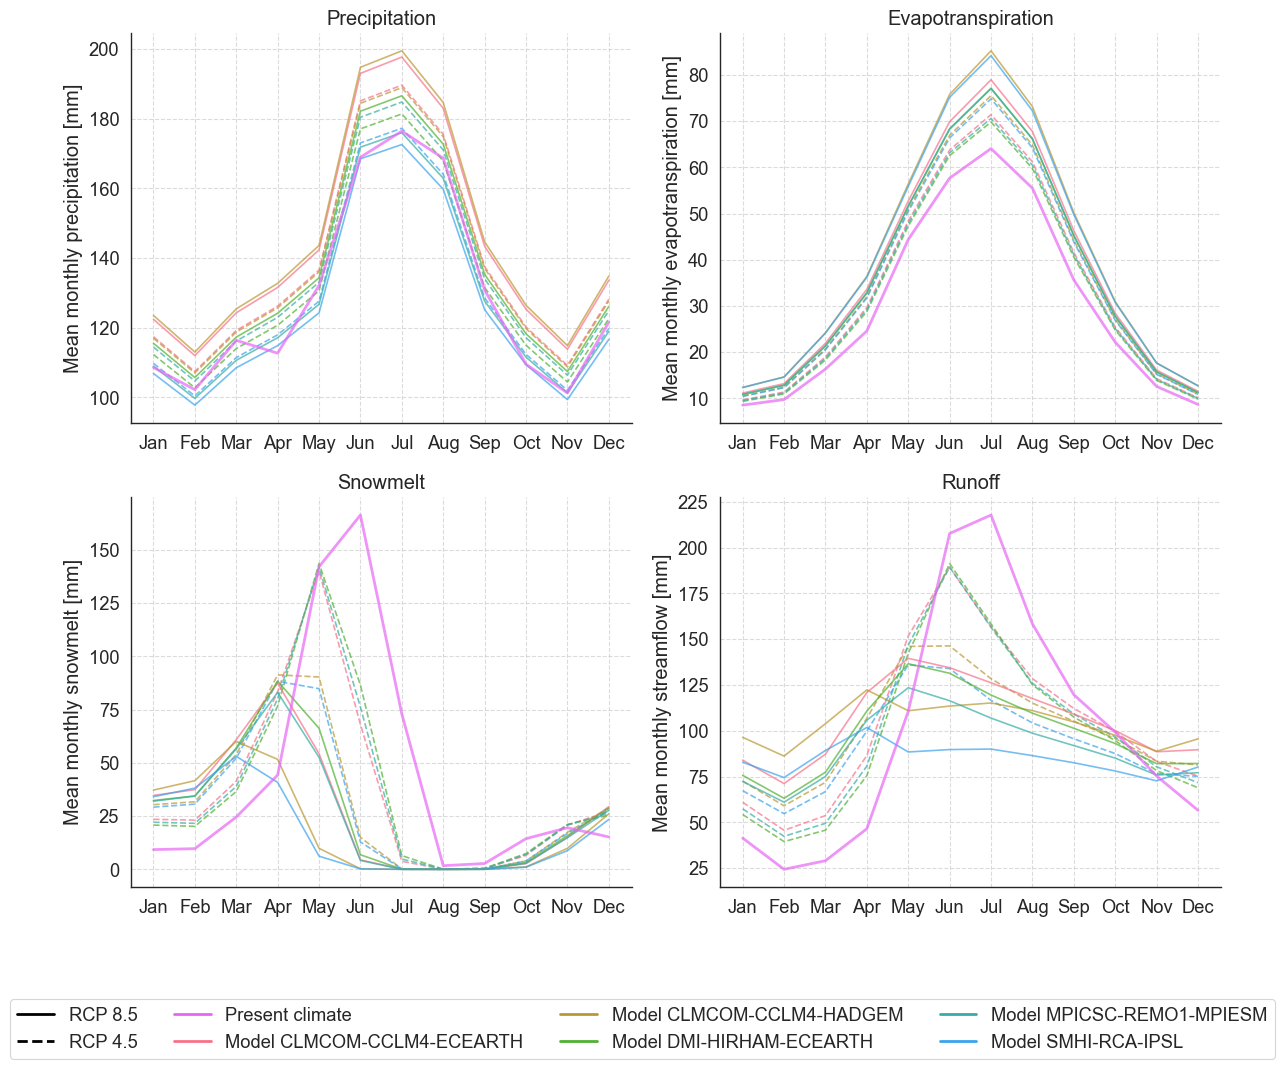

In [22]:
future_data_folder = "C:/Users/manon/OneDrive/Desktop/Watershed_Modeling/climate-impacts/data/Future_Climates"
results = run_model_for_future_climate(
    future_data_folder=future_data_folder,
    bucket_model=bucket_model,
)

# Prepare present data for plotting
present_monthly_mean, _ = group_by_month_with_ci(present_results)
present_monthly_mean['total_runoff'] = present_monthly_mean['Q_s'] + present_monthly_mean['Q_gw']

plot_climate_scenarios(
    results,
    present_results=present_monthly_mean,
) # Again, you can add the output_destination parameter to save the plot

### Simulate future streamflow using the future climate ensemble and the Bucket Model

In [23]:
folder_path = future_data_folder # Path to the folder containing the future climate scenarios
combined_df = simulate_and_aggregate_streamflows(folder_path, bucket_model, 50)

In [24]:
combined_df

,Simulation,Streamflow,Climate_Model,Scenario
0,1,1275.413029,CLMCOM_CCLM4_ECEARTH,RCP4.5
1,2,1256.040721,CLMCOM_CCLM4_ECEARTH,RCP4.5
2,3,1274.398822,CLMCOM_CCLM4_ECEARTH,RCP4.5
3,4,1258.074021,CLMCOM_CCLM4_ECEARTH,RCP4.5
4,5,1253.298628,CLMCOM_CCLM4_ECEARTH,RCP4.5
...,...,...,...,...
495,46,1023.473320,SMHI_RCA_IPSL,RCP8.5
496,47,1032.471845,SMHI_RCA_IPSL,RCP8.5
497,48,1015.414527,SMHI_RCA_IPSL,RCP8.5
498,49,1008.881437,SMHI_RCA_IPSL,RCP8.5


### Partition the hydrological (streamflow) uncertainties predicted in a future climate into their climatic sources – emission uncertainty, climate model uncertainty, and stochastic uncertainty

In [25]:
uncertainty = UncertaintyAnalysis(combined_df)

tu = uncertainty.calculate_tu('Streamflow')
eu, eu_partition = uncertainty.calculate_eu('Streamflow', tu)
cmu, cmu_partition = uncertainty.calculate_cmu('Streamflow', tu)
su, su_partition = uncertainty.calculate_su('Streamflow', tu)

print(f"Total Uncertainty: {tu}")
print(f"Emission Scenario Uncertainty: {eu} (Partition: {eu_partition})")
print(f"Climate Model Uncertainty: {cmu} (Partition: {cmu_partition})")
print(f"Stochastic Uncertainty: {su} (Partition: {su_partition})")

Total Uncertainty: 263.33
Emission Scenario Uncertainty: 17.36 (Partition: 0.07)
Climate Model Uncertainty: 190.48 (Partition: 0.72)
Stochastic Uncertainty: 89.4 (Partition: 0.34)
